# Handwritten Digit Recognition

## Setting up and Importing the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import math
import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from pathlib import Path

from PIL import Image
import cv2

import pandas as pd

from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

from torchinfo import summary
import os

## Data importing and preprocessing

In [2]:
def process_image(image):
    image = torch.from_numpy(np.array(image)).float()
    image = image.permute(1, 0)
    return image.unsqueeze(0)

transform = transforms.Compose([
    transforms.Lambda(process_image),
])

In [3]:
# Load EMNIST Letters dataset from torchvision
train_data = datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

In [4]:
# Adjust labels to be 0-25 (since EMNIST letters are 1-26)
train_data.targets = train_data.targets - 1
test_data.targets = test_data.targets - 1


In [5]:
# Class names (A-Z)
class_names = [chr(ord('A') + i) for i in range(26)]

In [6]:
# Create data loaders
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=0),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=0)
}

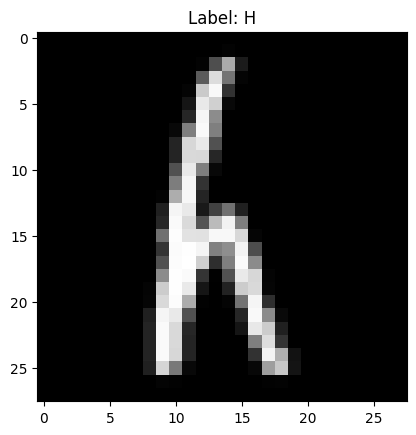

In [7]:
# Visualize a sample
data, target = next(iter(loaders['test']))
image = data[0].squeeze().numpy()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {class_names[target[0]]}")
plt.show()

## Data exploration

### Training Data

In [8]:
train_data

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
           )

### Testing_data

In [9]:
test_data

Dataset EMNIST
    Number of datapoints: 20800
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Lambda()
           )

### Dataset Shape and Size

In [10]:
train_data.data.shape

torch.Size([124800, 28, 28])

In [11]:
test_data.data.shape

torch.Size([20800, 28, 28])

In [12]:
train_data.targets.shape

torch.Size([124800])

In [13]:
train_data.targets

tensor([22,  6, 15,  ..., 12, 14, 18])

## Neural Network

In [14]:
DROPOUT = 0.3

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)  # Input: 1 channel (grayscale)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=DROPOUT)

        # Calculate flattened size correctly:
        # Input: 28x28
        # After conv1 (kernel=5, no padding): 28-5+1 = 24x24
        # After maxpool (kernel=2): 12x12
        # After conv2 (kernel=5): 12-5+1 = 8x8
        # After maxpool (kernel=2): 4x4
        self.flattened_size = 32 * 4 * 4  # 32 channels * 4x4 spatial dim

        # Classification head
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc1_drop = nn.Dropout(p=DROPOUT)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        # Input shape: [batch, 1, 28, 28]

        # Conv1 -> BN -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2))  # [B, 16, 12, 12]

        # Conv2 -> BN -> Dropout -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), kernel_size=2))  # [B, 32, 4, 4]

        # Flatten
        x = x.view(-1, self.flattened_size)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [16]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
# Print detailed summary (includes input/output shapes & parameters)
summary(model, input_size=(100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 26]                 --
├─Conv2d: 1-1                            [100, 16, 24, 24]         416
├─BatchNorm2d: 1-2                       [100, 16, 24, 24]         32
├─Conv2d: 1-3                            [100, 32, 8, 8]           12,832
├─BatchNorm2d: 1-4                       [100, 32, 8, 8]           64
├─Dropout2d: 1-5                         [100, 32, 8, 8]           --
├─Linear: 1-6                            [100, 128]                65,664
├─Dropout: 1-7                           [100, 128]                --
├─Linear: 1-8                            [100, 26]                 3,354
Total params: 82,362
Trainable params: 82,362
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 113.00
Input size (MB): 0.31
Forward/backward pass size (MB): 18.15
Params size (MB): 0.33
Estimated Total Size (MB): 18.79

## Creating the Dataset Training/Testing Mode

In [18]:
train_losses = []
train_accuracies = []

In [19]:
def train(epoch):
    model.train()  # Set model to training mode (enables dropout)
    running_loss = 0.0
    correct = 0  # To count correct predictions
    total = 0    # To count total samples

    for batch_idx, (data, target) in enumerate(loaders['train']):
        optimizer.zero_grad()  # Clear gradients
        output = model(data)  # Forward pass
        loss = loss_fn(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
        total += target.size(0)  # Count total samples

        # Print training progress
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                  f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}")

    # Calculate average loss and accuracy for the epoch
    avg_train_loss = running_loss / len(loaders['train'])
    train_accuracy = 100. * correct / total

    # Store training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"\nTrain Epoch: {epoch}\tAverage Loss: {avg_train_loss:.6f}\tAccuracy: {train_accuracy:.2f}%\n")

In [20]:
test_losses = []
test_accuracies = []

In [21]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Calculate average test loss and accuracy
    test_loss /= len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    
    # Store test loss and accuracy
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({accuracy:.2f}%)\n")

## Starting the Dataset Train/Test Process

In [22]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 124800 (0%)]	Loss: 3.296546
Train Epoch: 1 [2000 / 124800 (2%)]	Loss: 2.342782
Train Epoch: 1 [4000 / 124800 (3%)]	Loss: 1.870575
Train Epoch: 1 [6000 / 124800 (5%)]	Loss: 1.441084
Train Epoch: 1 [8000 / 124800 (6%)]	Loss: 1.665655
Train Epoch: 1 [10000 / 124800 (8%)]	Loss: 1.075176
Train Epoch: 1 [12000 / 124800 (10%)]	Loss: 1.052830
Train Epoch: 1 [14000 / 124800 (11%)]	Loss: 1.133917
Train Epoch: 1 [16000 / 124800 (13%)]	Loss: 0.817237
Train Epoch: 1 [18000 / 124800 (14%)]	Loss: 0.824608
Train Epoch: 1 [20000 / 124800 (16%)]	Loss: 0.896995
Train Epoch: 1 [22000 / 124800 (18%)]	Loss: 0.938513
Train Epoch: 1 [24000 / 124800 (19%)]	Loss: 0.740756
Train Epoch: 1 [26000 / 124800 (21%)]	Loss: 0.884886
Train Epoch: 1 [28000 / 124800 (22%)]	Loss: 0.766633
Train Epoch: 1 [30000 / 124800 (24%)]	Loss: 0.717034
Train Epoch: 1 [32000 / 124800 (26%)]	Loss: 0.721493
Train Epoch: 1 [34000 / 124800 (27%)]	Loss: 0.723477
Train Epoch: 1 [36000 / 124800 (29%)]	Loss: 0.831981
Train E

## Visualizing the results

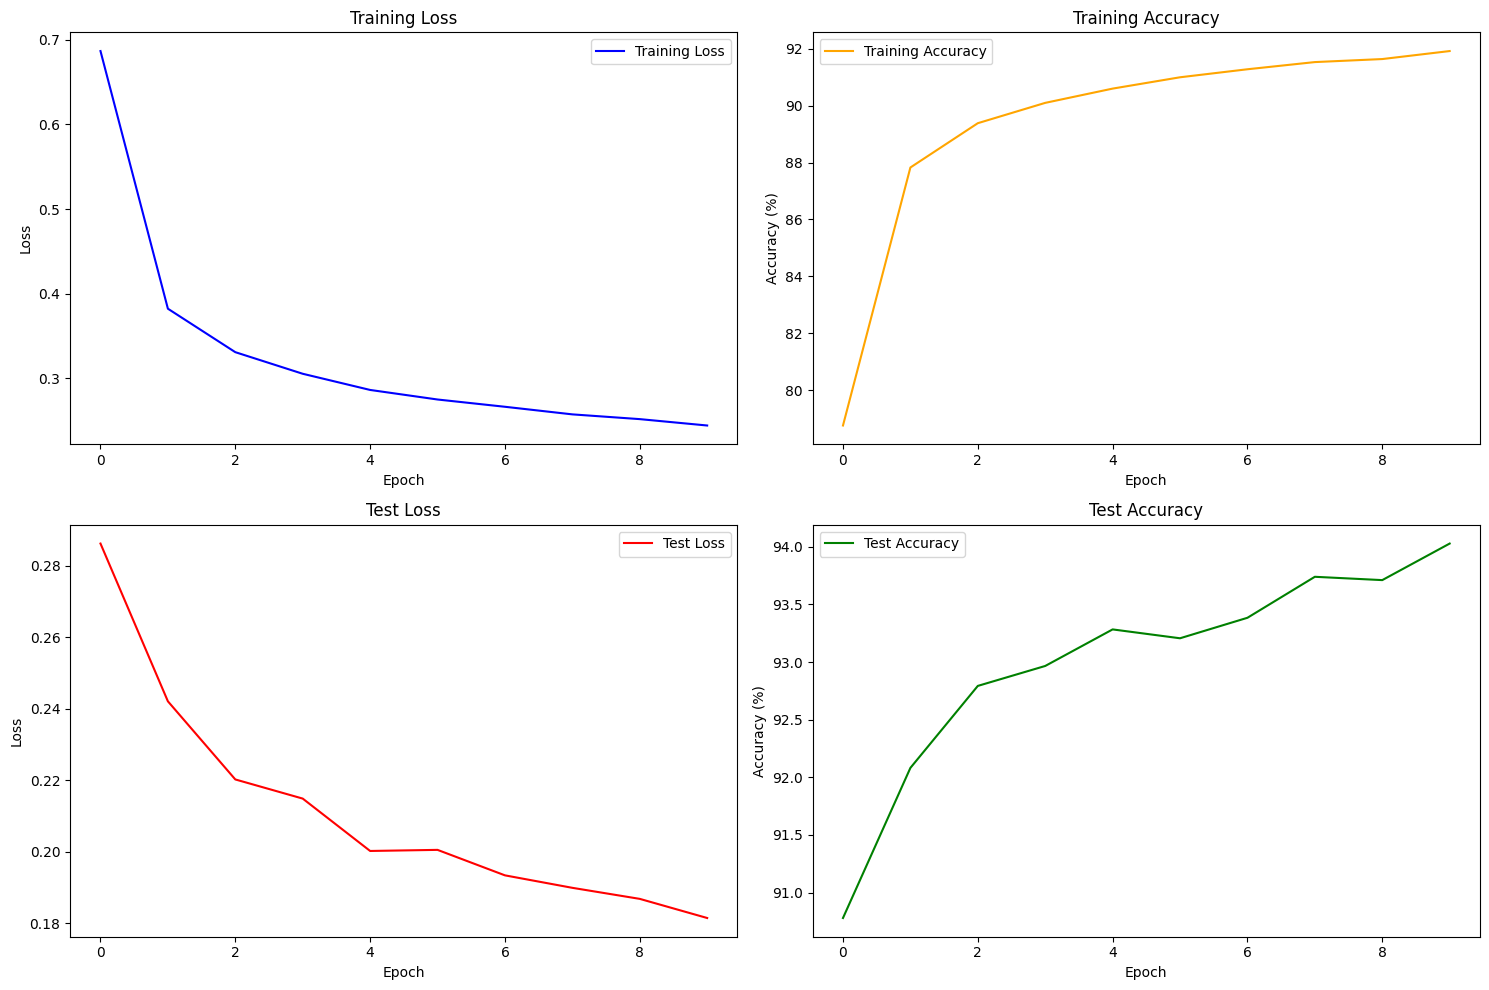

In [23]:
plt.figure(figsize=(15, 10))

# Plot Training Loss (Top Left)
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Training Accuracy (Top Right)
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

# Plot Test Loss (Bottom Left)
plt.subplot(2, 2, 3)
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Plot Test Accuracy (Bottom Right)
plt.subplot(2, 2, 4)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
def predict_and_visualize(test_data, model, index, class_names):
    # Set the model to evaluation mode
    model.eval()
    
    # Get the data and target from the test dataset
    data, target = test_data[index]
    
    # Prepare the data for the model
    data = data.unsqueeze(0)
    
    # Get the model's prediction
    with torch.no_grad():
        output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    
    # Get the predicted label and the real label
    predicted_label = class_names[prediction]
    real_label = class_names[target]  # Removed .item() since target is already an int
    
    # Print the prediction and real label
    print(f"Prediction: {predicted_label}")
    print(f"Real Label: {real_label}")
    
    # Prepare the image for visualization
    image = data.squeeze(0).squeeze(0).cpu().numpy()
    
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {predicted_label}\nReal Label: {real_label}")
    plt.axis('off')
    plt.show()

Prediction: A
Real Label: A


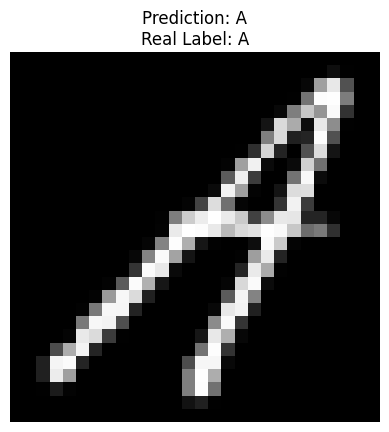

In [25]:
# Example usage
predict_and_visualize(test_data, model, 132, class_names)

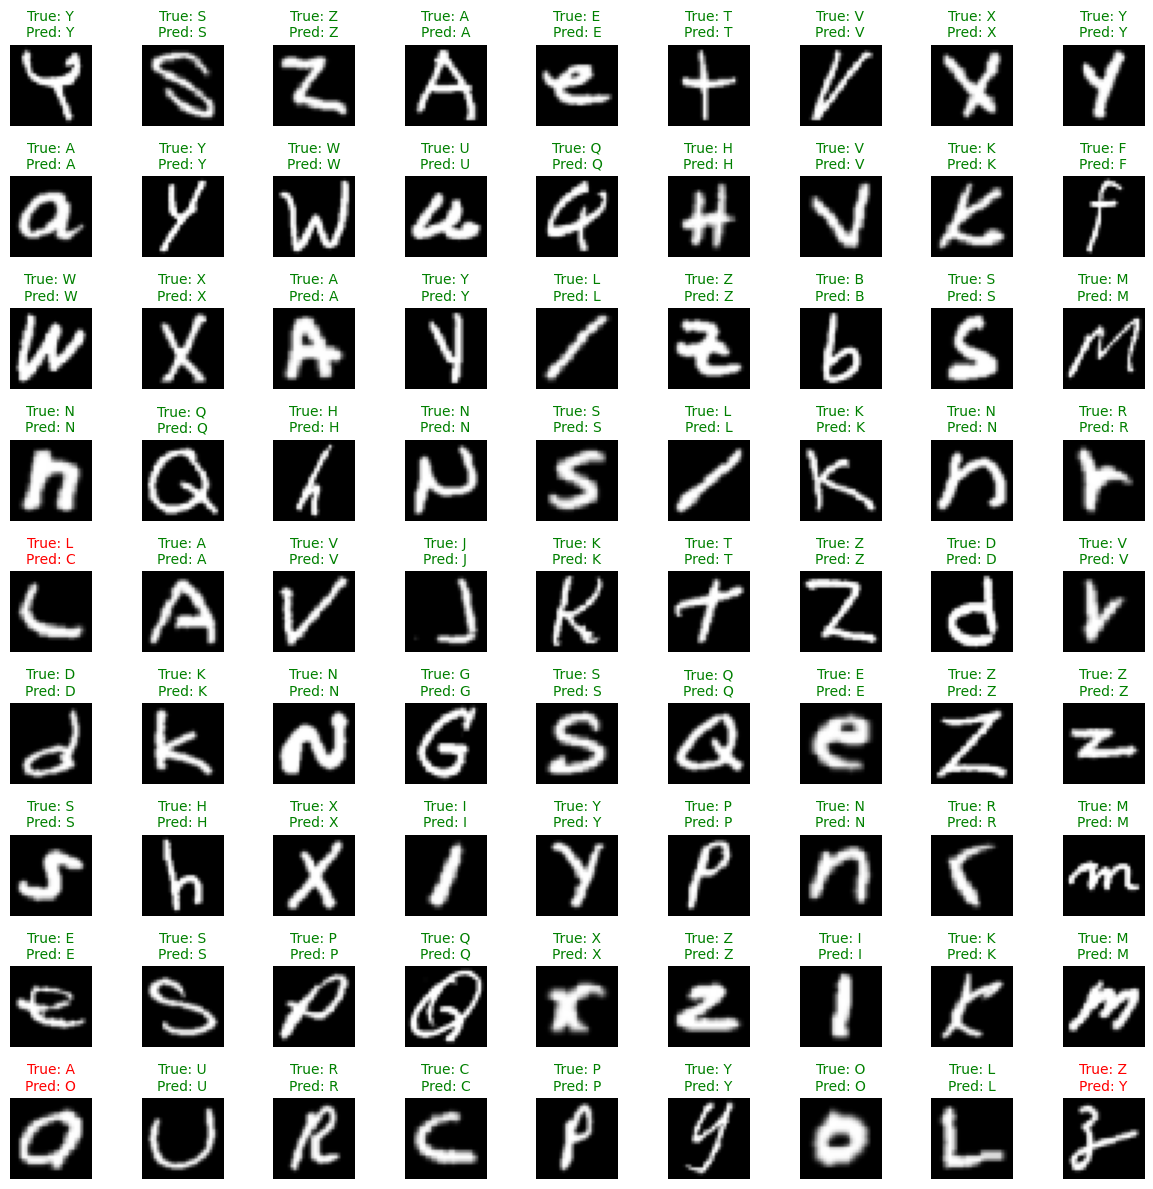

In [26]:
def plot_image_grid(model, data_loader, class_names, num_images=81):
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(9, 9, figsize=(12, 12))  # Create a 9x9 grid
    axes = axes.ravel()  # Flatten the axes to easily iterate

    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Perform predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(min(num_images, len(images))):
        ax = axes[i]
        ax.imshow(images[i].cpu().squeeze(0), cmap='gray')  # Show image

        # Get true and predicted labels using class_names
        true_label = class_names[labels[i].item()]
        pred_label = class_names[preds[i].item()]
        
        title_text = f"True: {true_label}\nPred: {pred_label}"
        
        if true_label == pred_label:
            ax.set_title(title_text, fontsize=10, c="g")  # green text if correct
        else:
            ax.set_title(title_text, fontsize=10, c="r")  # red text if wrong
            
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot a 9x9 grid of images with true and predicted labels
plot_image_grid(model, loaders['test'], class_names)

## Confusion Matrix

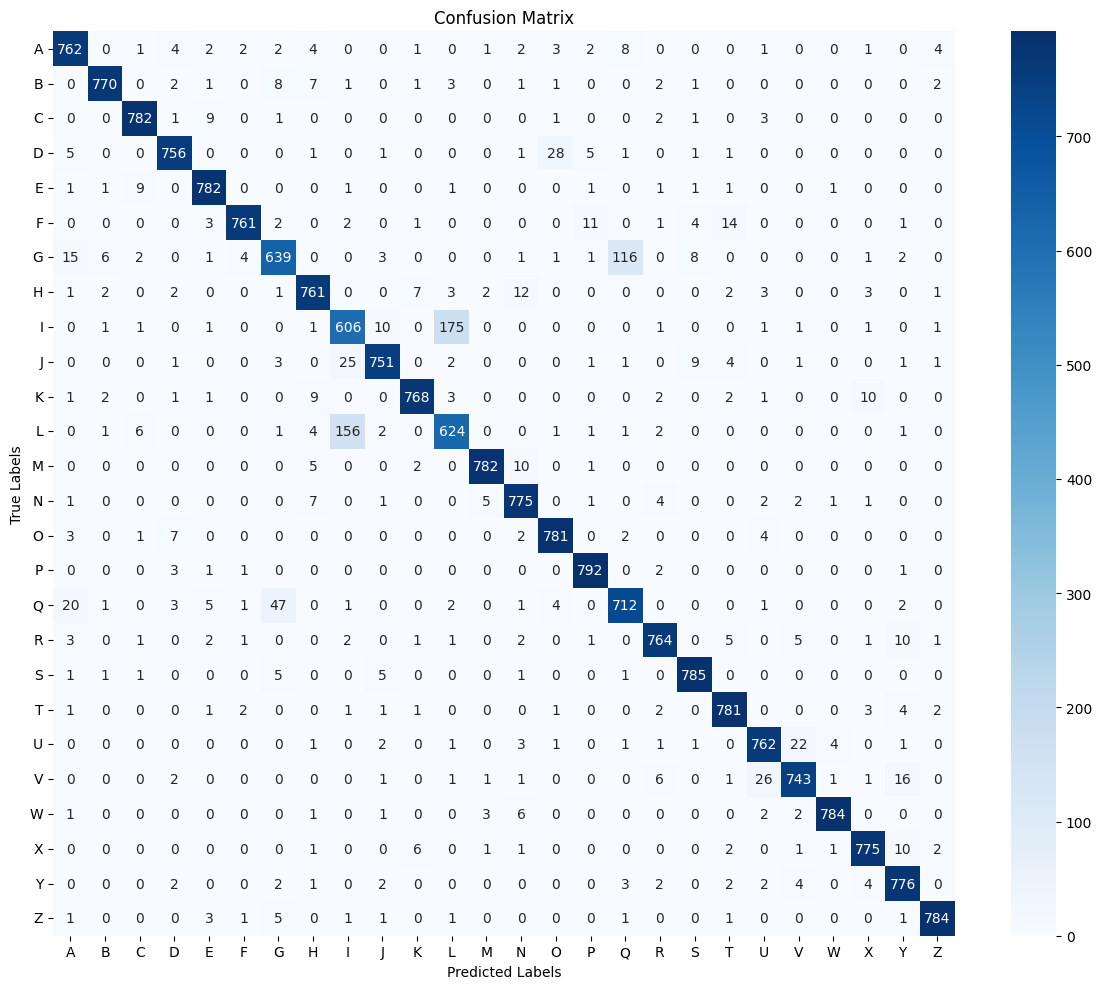

In [27]:
model.eval()  # Set the model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in loaders['test']:
        output = model(data)
        preds = output.argmax(dim=1)  # Get the predicted class indices
        # Map predicted indices to letters using class_names
        preds = [class_names[pred.item()] for pred in preds]
        # Map true labels to letters using class_names
        targets = [class_names[t.item()] for t in target]
        all_preds.extend(preds)
        all_targets.extend(targets)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute the confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=class_names)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.tight_layout()       # Adjust layout to prevent label cutoff
plt.show()

## Model exporting

In [28]:
model_path = 'models/emnist_cnn_model.pth'

In [29]:
# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

## Model loading

In [32]:
# Recreate the model architecture
loaded_model = CNN()

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

/var/folders/kt/1z0_7z79269b6p7bdrjn3m340000gn/T/ipykernel_23680/2585001405.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

Predicted: tensor([ 3, 25, 20, 10, 20,  3, 15, 15, 15, 19])
Actual: tensor([ 3, 25, 20, 10, 20,  3, 15, 15, 15, 19])


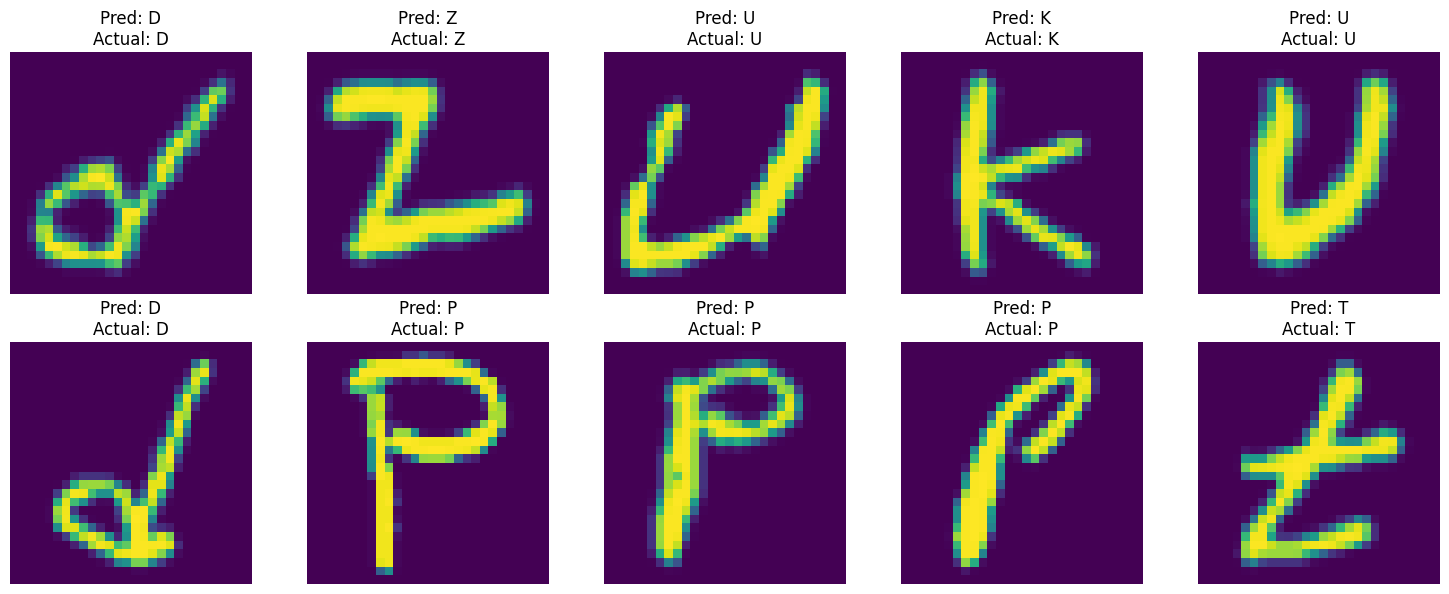

In [33]:
# Example: Predict using the loaded model
with torch.no_grad():
    test_data, test_target = next(iter(loaders['test']))
    test_data, test_target = test_data, test_target
    test_data = test_data
    output = loaded_model(test_data)
    predicted = output.argmax(dim=1)

    # Print the first few predictions
    print("Predicted:", predicted[:10])
    print("Actual:", test_target[:10])

    # Visualize the first few images along with their predicted and actual labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        # Convert image tensor to (H, W, C) format for visualization
        ax.imshow(test_data[i].cpu().permute(1, 2, 0))
        
        # Get the predicted and actual labels using class_names
        pred_label = class_names[predicted[i].item()] if predicted[i].item() < len(class_names) else "Unknown"
        actual_label = class_names[test_target[i].item()] if test_target[i].item() < len(class_names) else "Unknown"
        
        # Set the title with predicted and actual labels
        ax.set_title(f"Pred: {pred_label}\nActual: {actual_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Prediction on the new data

In [38]:
def predict_letters_from_directory(directory_path, model, class_names):
    """
    Predicts letters for all PNG images in the given directory and combines them into a string.

    Args:
        directory_path (str): Path to the directory containing PNG images.
        model (torch.nn.Module): Trained PyTorch model.
        class_names (list): List mapping class indices to letters (0='A', 1='B', etc.)

    Returns:
        str: Combined string of predicted letters from all images.
        list: List of tuples containing (image_path, predicted_letter, confidence) for each image.
    """
    # Get all PNG files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.png')]
    image_files.sort()  # Sort to maintain order
    
    predicted_string = ""
    predictions = []
    
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        
        # Load and process the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = image.resize((28, 28))
        image_array = np.array(image)
        
        image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, prediction = torch.max(probabilities, dim=1)
            confidence = confidence.item()
            prediction = prediction.item()
        
        # Map the prediction to a letter
        predicted_letter = class_names[prediction] if prediction < len(class_names) else "?"
        predicted_string += predicted_letter
        
        # Store individual prediction info
        predictions.append((image_path, predicted_letter, confidence))
        
        # Visualize the prediction
        plt.figure()
        plt.imshow(image_array, cmap='gray')  # Transpose back for display
        plt.title(f"Predicted: {predicted_letter}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()
    
    return predicted_string, predictions

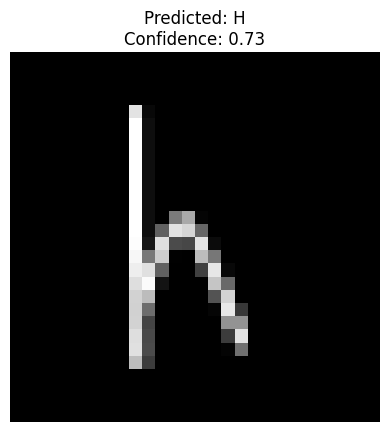

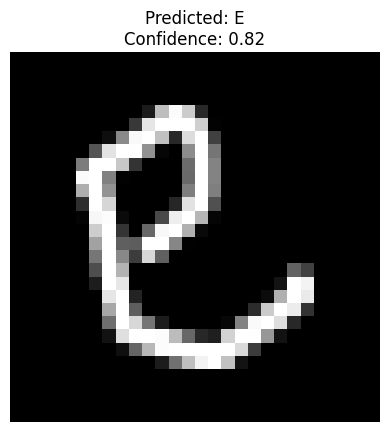

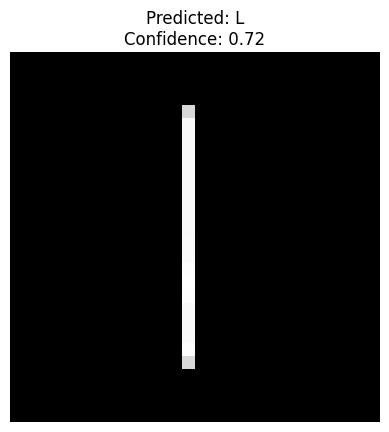

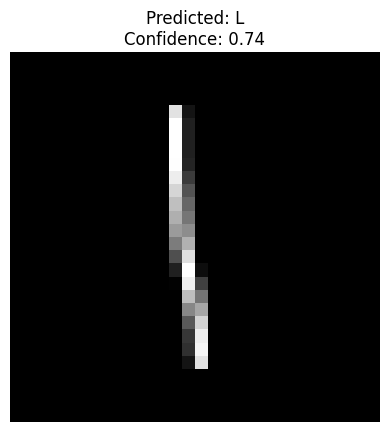

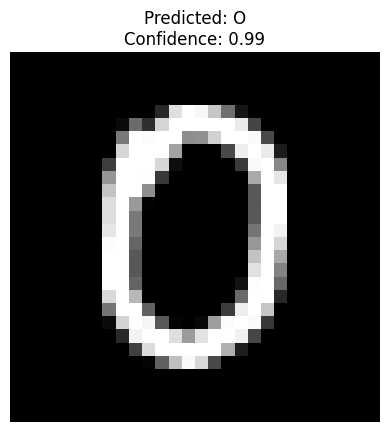

Combined predictions: HELLO

Individual predictions:
box_0.png: H (confidence: 0.73)
box_1.png: E (confidence: 0.82)
box_2.png: L (confidence: 0.72)
box_3.png: L (confidence: 0.74)
box_4.png: O (confidence: 0.99)


In [40]:
class_names = [chr(ord('A') + i) for i in range(26)]  # A-Z
directory_path = "output_grayscale/" 
predicted_string, individual_predictions = predict_letters_from_directory(directory_path, loaded_model, class_names)

print(f"Combined predictions: {predicted_string}")
print("\nIndividual predictions:")
for img_path, letter, conf in individual_predictions:
    print(f"{os.path.basename(img_path)}: {letter} (confidence: {conf:.2f})")